In [1]:
import ROOT
import uproot
import numpy as np
import array as array
import math
import matplotlib.pyplot as plt
import pickle as pkl
import hist
#import statistics as st
ROOT.gStyle.SetOptStat(000000)

In [2]:
with open("latest_pkl/pythia_syst_0302.pkl", "rb") as f:
    output = pkl.load( f )

with open("latest_pkl/data_combined.pkl", "rb") as f:
    output_data = pkl.load( f )

In [3]:
groomed = False
closure = False

In [4]:
if groomed:
    s_response = 'response_matrix_g'
    s_data = 'ptjet_mjet_g_reco'
else:
    s_response = 'response_matrix_u'
    s_data = 'ptjet_mjet_u_reco'
    
resp_hist = output[s_response][{'systematic':'nominal'}].project('ptgen', 'ptreco', 'mgen', 'mreco')
resp_hist

Hist(
  Variable([200, 260, 350, 460, 13000], name='ptgen', label='$p_{T,GEN}$ (GeV)'),
  Variable([200, 260, 350, 460, 13000], name='ptreco', label='$p_{T,RECO}$ (GeV)'),
  Variable([0, 10, 20, 40, 60, 80, 100, 120, 140, 160, 200, 13000], name='mgen', label='Mass (GeV)'),
  Variable(array([0.0e+00, 5.0e+00, 1.0e+01, 1.5e+01, 2.0e+01, 3.0e+01, 4.0e+01,
       5.0e+01, 6.0e+01, 7.0e+01, 8.0e+01, 9.0e+01, 1.0e+02, 1.1e+02,
       1.2e+02, 1.3e+02, 1.4e+02, 1.5e+02, 1.6e+02, 1.8e+02, 2.0e+02,
       6.2e+03, 1.3e+04]), name='mreco', label='$m_{RECO}$ (GeV)'),
  storage=Weight()) # Sum: WeightedSum(value=223326, variance=21546.3) (WeightedSum(value=260885, variance=28126.2) with flow)

In [5]:
bin_by_bin = True

In [6]:
ipt = 3
if not bin_by_bin:
    mresp_hist = resp_hist.project( 'mgen', 'mreco')
else:
    mresp_hist = resp_hist[ipt,:,:,:]
    mresp_hist = mresp_hist.project( 'mgen', 'mreco')
    

In [7]:
mgenbins = mresp_hist.axes['mgen']
mrecobins = mresp_hist.axes['mreco']

In [8]:
mgenbins

Variable([0, 10, 20, 40, 60, 80, 100, 120, 140, 160, 200, 13000], name='mgen', label='Mass (GeV)')

In [9]:
np.array(mrecobins.edges, dtype = int)

array([    0,     5,    10,    15,    20,    30,    40,    50,    60,
          70,    80,    90,   100,   110,   120,   130,   140,   150,
         160,   180,   200,  6200, 13000])

In [10]:


nmgenbins = len(mgenbins.edges) - 1
nmrecobins = len(mrecobins.edges) - 1

In [11]:
mBinsReco = array.array('d', [    0,     5,    10,    15,    20,    30,    40,    50,    60,
          70,    80,    90,   100,   110,   120,   130,   140,   150,
         160,   180,   200,  6200, 13000])
mBinsGen =  array.array('d', [0, 10, 20, 40, 60, 80, 100, 120, 140, 160, 200, 13000])

generatorBinning = ROOT.TUnfoldBinning("generator")
signalBinning = generatorBinning.AddBinning("signal") 
signalBinning.AddAxis("massgen",nmgenbins,mBinsGen,
                        False, # needed for fakes
                        False # overflow bin
                        )


detectorBinning = ROOT.TUnfoldBinning("detector") 
detectorDistribution=detectorBinning.AddBinning("detectordistribution")
detectorDistribution.AddAxis("mass",nmrecobins,mBinsReco,
                        False, # no underflow bin (not reconstructed)
                        False # overflow bin
                        )

True

In [12]:
M = ROOT.TUnfoldBinning.CreateHistogramOfMigrations(generatorBinning,detectorBinning,"M")

h = detectorBinning.CreateHistogram("h")

    
htrue = generatorBinning.CreateHistogram("htrue")

In [13]:
M_np = mresp_hist.values()
M_error_np = mresp_hist.variances()**0.5
if closure:
    h_np = np.sum(M_np, axis = 0)
    h_error_np = np.sum(mresp_hist.variances(), axis = 0)**0.5
else:
    h_np = output_data[s_data].project('ptreco','mreco')[ipt,:]
    h_np.underflow = 0
    h_np.overflow = 0
    h_np = h_np.project('mreco').values()
    h_error_np  = h_np**0.5

htrue_np = np.sum(M_np, axis = 1 )
htrue_error_np = np.sum(mresp_hist.variances(), axis = 1)**0.5

In [14]:
np.sum(M_np)

np.float64(11641.192286897858)

In [15]:
for i in range(h_np.shape[0]):
    h.SetBinContent(i+1, h_np[i])
    h.SetBinError(i+1, h_error_np[i])
for j in range(htrue_np.shape[0]):
    htrue.SetBinContent(j+1, htrue_np[j])
    htrue.SetBinError(j+1, htrue_error_np[j])

In [16]:
for i in range(M_np.shape[0]):
    for j in range(M_np.shape[1]):
        M.SetBinContent(i+1, j+1, M_np[i,j])
        M.SetBinError(i+1, j+1, M_error_np[i,j])

In [17]:
h_np = np.sum(M_np, axis = 0)
htrue_np = np.sum(M_np, axis = 1 )



for i in range(M_np.shape[0]):
    for j in range(M_np.shape[1]):
        M.SetBinContent(i+1, j+1, M_np[i,j])
        M.SetBinError(i+1, j+1, M_error_np[i,j])

In [18]:
cM = ROOT.TCanvas()
M.Draw('colz')
cM.SetLogz()
cM.Draw()

In [19]:
integral_M = M.Integral()
integral_h = h.Integral()

# Scale M to match the sum of h
if integral_M > 0:
    M.Scale(integral_h / integral_M)

np.float64(19.99241578941651)

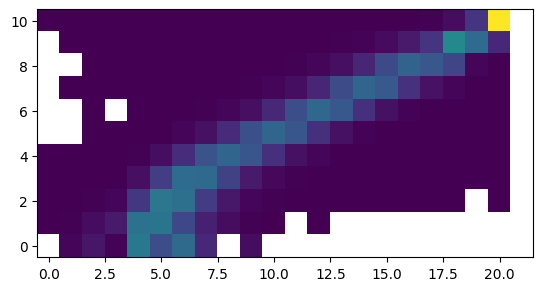

In [20]:
import numpy as np

matrix = M_np.copy()

def prob_m(m):
    m = np.copy(m)
    for i in range(m.shape[0]):
        sum_i = m[i].sum()
        m[i]/= sum_i
    return m
    
p_m = prob_m(matrix)
plt.imshow(np.ma.masked_less_equal(p_m,0), origin = 'lower')
np.linalg.cond(p_m)


In [21]:
M_np.shape

(11, 22)

In [22]:
cP = ROOT.TCanvas()
proj_gen = M.ProjectionX()
proj_gen.Draw()
htrue.SetMarkerColor(4)
htrue.SetMarkerStyle(4)
htrue.SetMarkerSize(1)
htrue.SetMarkerColor(6)

htrue.Draw('same *')
cP.Draw()

In [23]:
cP = ROOT.TCanvas()
proj_reco = M.ProjectionY()
proj_reco.Draw()
h.SetLineColor(3)
h.SetMarkerColor(3)
h.SetMarkerStyle(3)
h.SetMarkerSize(0.2)

h.Draw('same *')
# Adjust the y-axis range to accommodate both histograms
# y_max = max(proj_reco.GetMaximum(), h.GetMaximum()) * 1.1  # Add 10% margin
# y_min = min(proj_reco.GetMinimum(), h.GetMinimum()) * 0.9  # Reduce by 10% if needed

# proj_reco.SetMaximum(y_max)
# proj_reco.SetMinimum(y_min)
cP.Update()
cP.RedrawAxis()
cP.Draw()

In [24]:
# cP = ROOT.TCanvas()

# proj_reco = M.ProjectionY()
# proj_reco.Scale(1.0 / proj_reco.Integral())  # Normalize by sum of bins
# proj_reco.Draw()

# h.SetLineColor(3)
# h.SetMarkerColor(3)
# h.SetMarkerStyle(3)
# h.SetMarkerSize(0.1)

# h.Scale(1.0 / h.Integral())  # Normalize h by sum of bins
# h.Draw("same *")

# # Adjust the y-axis range
# y_max = max(proj_reco.GetMaximum(), h.GetMaximum()) * 1.1  # Add 10% margin
# y_min = min(proj_reco.GetMinimum(), h.GetMinimum()) * 0.9  # Reduce by 10% if needed

# proj_reco.SetMaximum(y_max)
# proj_reco.SetMinimum(y_min)

# cP.Update()
# cP.RedrawAxis()
# cP.Draw()


In [25]:
orientation = ROOT.TUnfold.kHistMapOutputHoriz
regMode = ROOT.TUnfold.kRegModeCurvature
con = ROOT.TUnfold.kEConstraintArea #ROOT.TUnfold.kEConstraintArea
mode =  ROOT.TUnfoldDensity.kDensityModeBinWidth
axisSteering =  "*[b]"

u = ROOT.TUnfoldDensity(M, orientation, regMode, con, mode, generatorBinning, detectorBinning, "signal", axisSteering)



Info in <TUnfold::SetConstraint>: fConstraint=1
Info in <TUnfold::TUnfold>: underflow and overflow bin do not depend on the input data
Info in <TUnfold::TUnfold>: 22 input bins and 11 output bins
Info in <TUnfoldDensity::TUnfold>: *NOT* unfolding bin #0
Info in <TUnfoldDensity::TUnfold>: *NOT* unfolding bin #12
Info in <TUnfoldDensity::RegularizeOneDistribution>: regularizing signal regMode=3 densityMode=1 axisSteering=*[b]


In [26]:
u.SetInput( h )

3

Warning in <TUnfoldDensity::SetInput>: 3/22 input bins have zero error, and are ignored.


In [27]:
graph = ROOT.MakeNullPointer(ROOT.TGraph)
spline = ROOT.MakeNullPointer(ROOT.TSpline)
#u.DoUnfold(4.787)
u.ScanTau(50,0,0,spline)
#u.ScanLcurve(50, 0, 0,graph)

46

Info in <TUnfoldDensity::ScanTau>: logtau=-Infinity y=0.835115 X=1.039339 Y=-0.895378
Info in <TUnfoldDensity::ScanTau>: logtau=1.091963 y=0.692877 X=1.133407 Y=-1.099253
Info in <TUnfoldDensity::ScanTay>: logtau=0.591963 y=0.814924 X=1.042367 Y=-0.934773
Info in <TUnfoldDensity::ScanTay>: logtau=0.091963 y=0.832984 X=1.039381 Y=-0.900267
Info in <TUnfoldDensity::ScanTay>: logtau=-0.408037 y=0.834900 X=1.039339 Y=-0.895881
Info in <TUnfoldDensity::ScanTau>: logtau=-0.158037 y=0.834438 X=1.039343 Y=-0.896958
Info in <TUnfoldDensity::ScanTau>: logtau=0.341963 y=0.828476 X=1.039725 Y=-0.909904
Info in <TUnfoldDensity::ScanTau>: logtau=0.841963 y=0.776965 X=1.058496 Y=-0.989512
Info in <TUnfoldDensity::ScanTau>: logtau=-0.283037 y=0.834734 X=1.039340 Y=-0.896270
Info in <TUnfoldDensity::ScanTau>: logtau=-0.033037 y=0.833913 X=1.039352 Y=-0.898165
Info in <TUnfoldDensity::ScanTau>: logtau=0.216963 y=0.831347 X=1.039468 Y=-0.903870
Info in <TUnfoldDensity::ScanTau>: logtau=0.466963 y=0.82348

In [28]:
o_0 = u.GetOutput('output','Unfolded Mass p_{T} bin','signal','*', ROOT.kTRUE)

Error in <TUnfoldBinning::DecodeAxisSteering>: steering "*" does not end with [options]
Error in <TUnfoldBinning::DecodeAxisSteering>: steering "*" does not end with [options]


In [29]:
u.GetTau()

10.701959302699535

In [30]:
%jsroot 

In [31]:
h2 = ROOT.TH1D('input', 'input', nmrecobins, mBinsReco)
h_mc = ROOT.TH1D('mcreco', 'mcreco', nmrecobins, mBinsReco)

for i in range(1, h2.GetNbinsX()+1):
    h2.SetBinContent(i, h.GetBinContent(i))
    h_mc.SetBinContent(i, proj_reco.GetBinContent(i))
    
h2 = h2.Rebin(2)
h_mc = h_mc.Rebin(2)

cO = ROOT.TCanvas()
o = o_0.Clone('Unfolded Mass for full p_{T} spectrum')
o.GetXaxis().SetTitle('Jet Mass (GeV)')
o.GetYaxis().SetTitle('Counts/Bin width')

htrue2 = o.Clone()
htrue2.Reset()
for i in range(1, o.GetNbinsX()+1):
    o.SetBinContent(i, o_0.GetBinContent(i)/mgenbins.widths[i-1])
    o.SetBinError(i, o_0.GetBinError(i)/mgenbins.widths[i-1])
    
    h2.SetBinContent(i, h2.GetBinContent(i)/mgenbins.widths[i-1])
    h2.SetBinError(i, h2.GetBinError(i)/mgenbins.widths[i-1])

    h_mc.SetBinContent(i, h_mc.GetBinContent(i)/mgenbins.widths[i-1])
    h_mc.SetBinError(i, h_mc.GetBinError(i)/mgenbins.widths[i-1])
    
    htrue2.SetBinContent(i, htrue.GetBinContent(i)/mgenbins.widths[i-1])
    htrue2.SetMarkerStyle(32)
    htrue2.SetMarkerColor(6)
    htrue2.SetLineColor(6)
    
    h2.SetMarkerStyle(3)
    h2.SetMarkerColor(2)
    h2.SetLineColor(2)
o.SetMarkerStyle(25)    
o.SetFillColor(0)
htrue2.Scale(o.Integral()/htrue2.Integral() )

o.Draw('same e') 
h2.Draw('same e')
h_mc.Draw('same')

legend = ROOT.TLegend(0.7, 0.7, 0.9, 0.9)
legend.AddEntry(o, 'Unfolded', 'pe')
legend.AddEntry(htrue2, 'Truth')
legend.AddEntry(h2, 'Input (Gen Binned)')
legend.Draw()
htrue2.Draw('same e')
htrue2.GetXaxis().SetRangeUser(0,200)
h2.GetXaxis().SetRangeUser(0,200)
o.GetXaxis().SetRangeUser(0,200)
cO.Draw()

In [32]:
import ROOT

# Create a canvas
cnew = ROOT.TCanvas("cnew", "Canvas", 800, 600)

# Set histogram styles
h2.SetLineColor(ROOT.kRed)  # Data in red
h2.SetLineWidth(2)
h2.SetMarkerStyle(20)
h2.SetMarkerColor(ROOT.kRed)

h_mc.SetLineColor(ROOT.kBlue)  # MC in blue
h_mc.SetLineWidth(2)
h_mc.SetLineStyle(2)  # Dashed line for MC

# Draw histograms
h2.Draw("E")  # "E" option ensures error bars are shown
h_mc.Draw("HIST SAME")  # "HIST" draws as a histogram, "SAME" overlays it

# Add axis labels and title
h2.SetTitle("Comparison of Data and MC")  
h2.GetXaxis().SetTitle("Observable (units)")  # Replace with actual x-axis variable
h2.GetYaxis().SetTitle("Events")

# Add a legend
legend = ROOT.TLegend(0.7, 0.7, 0.9, 0.85)  # (x1, y1, x2, y2) in NDC coordinates
legend.AddEntry(h2, "Data", "lep")  # "lep" -> line, error bars, and points
legend.AddEntry(h_mc, "MC", "l")  # "l" -> line only
legend.SetBorderSize(0)
legend.SetTextSize(0.03)
legend.Draw()

# Update and draw the canvas
cnew.Update()
cnew.Draw()


In [33]:
h2.GetMean()

78.46902681621671

In [34]:
h_mc.GetMean()

83.10993269020298

In [35]:
83/78

1.064102564102564

In [36]:
error_M = u.GetEmatrixTotal('Covariance')
cE = ROOT.TCanvas()
error_M.Draw('colz')
error_M.GetXaxis().SetRangeUser(0,200)
error_M.GetYaxis().SetRangeUser(0,200)
#cE.SetLogz()
cE.Draw()


In [37]:
o_0.GetBinError(2)

44.56477634400326

In [38]:
o_0.Integral()

17628.0

In [39]:
file = ROOT.TFile.Open("puppiCorr_2018.root")

In [40]:
file.ls()

TFile**		puppiCorr_2018.root	
 TFile*		puppiCorr_2018.root	
  KEY: TF1	puppiJECcorr_gen;1	1+0.0231069*(x**(-2*(0.0704761)))-8.42917*(x**(-1))
  KEY: TF1	puppiJECcorr_reco_0eta1v3;1	(1.06263222851)+(2.97332221436e-05)*x+(-7.31785851974e-09)*(x**2)+(2.53798731754e-13)*(x**3)+(1.68571767997e-16)*(x**4)+(-6.77123709437e-20)*(x**5)
  KEY: TF1	puppiJECcorr_reco_1v3eta2v5;1	(1.11889161475)+(2.68579882197e-05)*x+(-4.30234840782e-09)*(x**2)+(8.27000377942e-12)*(x**3)+(1.45823446695e-15)*(x**4)+(-1.65979484436e-18)*(x**5)


In [41]:
histgen =  file.Get("puppiJECcorr_gen")
hist1 = file.Get("puppiJECcorr_reco_0eta1v3")
hist2 = file.Get("puppiJECcorr_reco_1v3eta2v5")



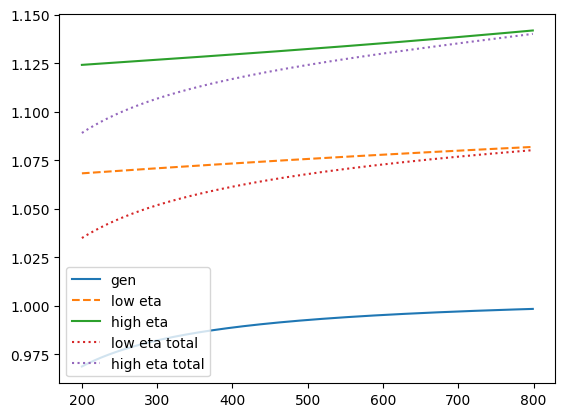

In [42]:
sf = []
sf_1 = []
sf_2  = []

pt_list = []
for pt in range(200,800):
    sf.append(histgen.Eval(pt))
    sf_1.append(hist1.Eval(pt))
    sf_2.append(hist2.Eval(pt))
    pt_list.append(pt)


    

plt.plot(pt_list, sf, label = 'gen')
plt.plot(pt_list, sf_1,ls = '--', label =  'low eta')
plt.plot(pt_list, sf_2, label = 'high eta')
plt.plot(pt_list, np.array(sf)*np.array(sf_1), label = 'low eta total', ls = 'dotted')
plt.plot(pt_list, np.array(sf)*np.array(sf_2), label = 'high eta total', ls = 'dotted')
plt.legend()

In [44]:
cov = np.diag(h_np)

In [45]:
cov.shape

(22, 22)

In [46]:
mresp_hist

Hist(
  Variable([0, 10, 20, 40, 60, 80, 100, 120, 140, 160, 200, 13000], name='mgen', label='Mass (GeV)'),
  Variable(array([0.0e+00, 5.0e+00, 1.0e+01, 1.5e+01, 2.0e+01, 3.0e+01, 4.0e+01,
       5.0e+01, 6.0e+01, 7.0e+01, 8.0e+01, 9.0e+01, 1.0e+02, 1.1e+02,
       1.2e+02, 1.3e+02, 1.4e+02, 1.5e+02, 1.6e+02, 1.8e+02, 2.0e+02,
       6.2e+03, 1.3e+04]), name='mreco', label='$m_{RECO}$ (GeV)'),
  storage=Weight()) # Sum: WeightedSum(value=11641.2, variance=186.169)

In [64]:
import svdunfold


h_meas = output_data[s_data].project('ptreco','mreco')[ipt,hist.rebin(2)].to_numpy()
cov = np.diag(h_meas[0])
cov[0,0] = 1

unfold = svdunfold.SVDunfold(mresp_hist.project('mgen').to_numpy(), h_meas, mresp_hist[:, hist.rebin(2)].values().T, cov)
#unfold = svdunfold.SVDunfold(mresp_hist.project('mgen').to_numpy(), mresp_hist.project('mreco')[hist.rebin(2)].to_numpy(), mresp_hist[:, hist.rebin(2)].values().T, cov)
unfold.transform_system()

In [65]:
unfold.unfold(k=2)

In [66]:
unfold.get_unfolded_distribution()

array([7.14262747e-01, 3.15880062e+01, 1.18189963e+03, 3.74037289e+03,
       4.02511226e+03, 2.75692627e+03, 1.76840829e+03, 1.15395368e+03,
       7.89496161e+02, 9.10484570e+02, 6.40171458e+02])

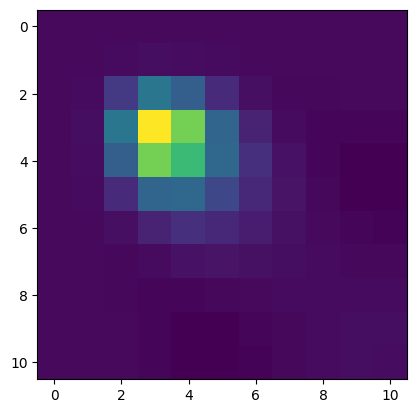

In [67]:
plt.imshow(unfold.get_unfolded_cov_matrix())

In [68]:
errors = np.diag(unfold.get_unfolded_cov_matrix())**0.5

In [69]:
o_np = []
for i in range(1, o.GetNbinsX()+1):
    o_np.append(o_0.GetBinContent(i))

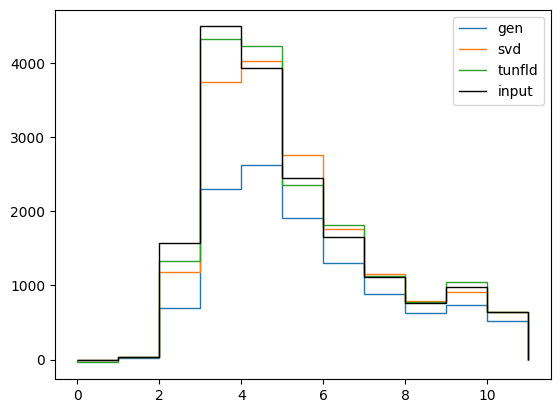

In [70]:
plt.stairs(htrue_np, label = 'gen')
plt.stairs(unfold.get_unfolded_distribution(), label = 'svd')
plt.stairs(o_np, label = 'tunfld')
plt.stairs(h_meas[0], label = 'input', color = 'k')
plt.legend()


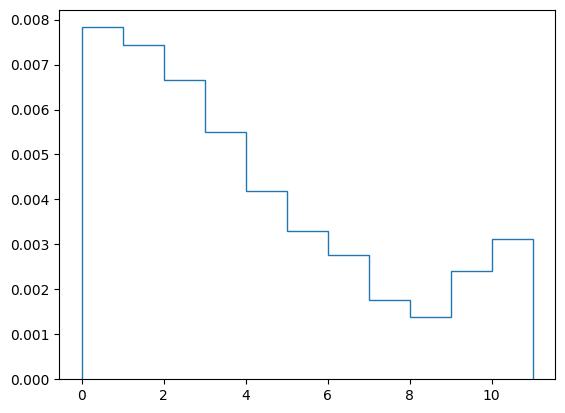

In [62]:
plt.stairs(errors/unfold.get_unfolded_distribution())

In [ ]:
o.